In [14]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 994 ms (started: 2022-12-02 03:56:39 +00:00)


In [3]:
#install weights and biases for data logging
# 26fd22ecbe5d0d2e53f656dbee7cedad16503a06
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
 

In [15]:
#time all processes to measure network efficiency
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.07 s (started: 2022-12-02 03:56:44 +00:00)


In [16]:
!pip install torchlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 6.29 s (started: 2022-12-02 03:56:48 +00:00)


**Imports**

In [45]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations
import wandb
import torchlm
from numpy import random
from google.colab.patches import cv2_imshow

time: 20.3 ms (started: 2022-12-02 04:24:23 +00:00)


**Config**

In [18]:
#paths
TEST_ROOT_PATH = '/content/gdrive/MyDrive/300W'
TRAIN_ROOT_PATH = '/content/gdrive/MyDrive/fakeitdataset/dataset_1000'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

#set to True if you want to augment traning data
#Augmentations = {Random Mask, Random Rotation}
DATA_AUGMENTATION = True

time: 6.02 ms (started: 2022-12-02 03:56:54 +00:00)


**Utility**

In [81]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.astype(np.uint8))
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.astype(np.uint8))
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img,(1,2,0))
        print('visualize img.shape',img.shape)
        #cv2.imwrite('/content/gdrive/MyDrive/mobilenet/img_'+str(i)+'.jpg',img)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    #cv2_imshow(img)
    plt.show()
    plt.close()
  

time: 15.6 ms (started: 2022-12-02 05:09:31 +00:00)


**Dataset Class**

In [73]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image

def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target


class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path,train=True):
        self.data = samples
        self.path = path
        self.resize = 224
        self.train = train
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints
    
    def __getitem__(self, index):
      
        image = cv2.imread(f"{self.path}/{self.data[index]}")

        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))

        
        # again reshape to add grayscale channel format
        image = image / 255.0

        cv2_imshow(image)
        # transpose for getting the channel size to index 0
        
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = self.normalize(image)
        
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]

        if DATA_AUGMENTATION == True and self.train == True:
            angle = int(np.random.choice([i for i in range(40)]))
            print('angle',angle)

            #convert tensor to PIL Image
            transform = transforms.ToPILImage()
            image = transform(image)

            display(image)

            #convert keypoints to a list
            keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
            keypoints = keypoints[:,0]

            image,keypoints = random_rotate(image,keypoints,angle)

            display(image)

            #convert PIL Image to Tensor
            transform = transforms.ToTensor()
            image = transform(image)
            
            keypoints = keypoints.reshape(-1, 2)
            print('image.shape',image.shape,'keypoints.shape',keypoints.shape)
            
            #image = transforms.functional.rotate(image,angle)
          
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500]) 
      return data

time: 14.8 ms (started: 2022-12-02 04:56:40 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


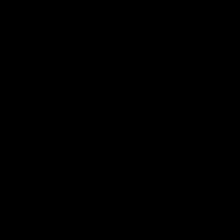

angle 27


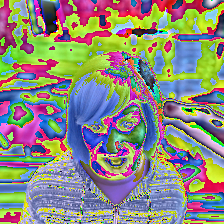

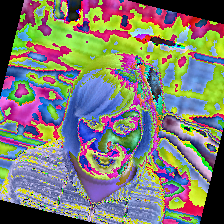

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


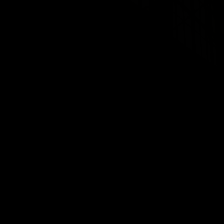

angle 39


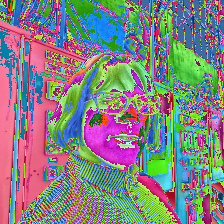

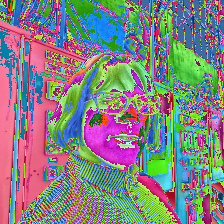

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


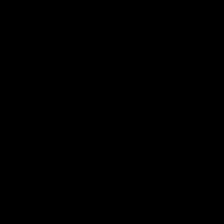

angle 2


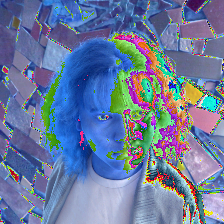

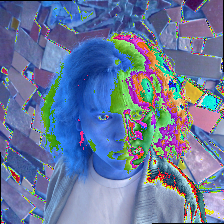

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


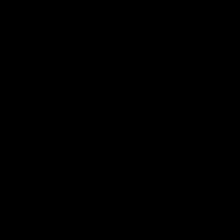

angle 27


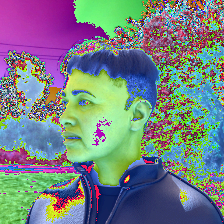

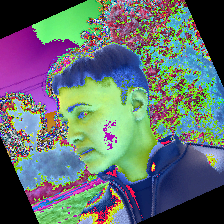

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


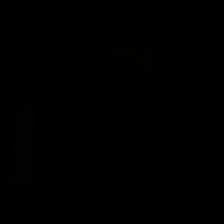

angle 37


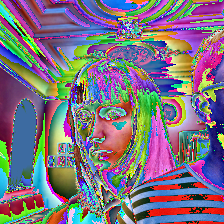

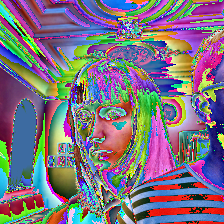

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


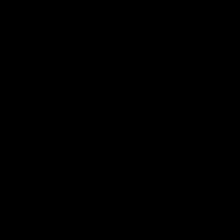

angle 15


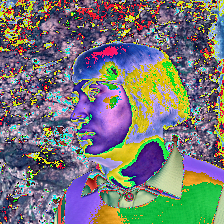

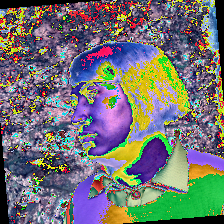

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


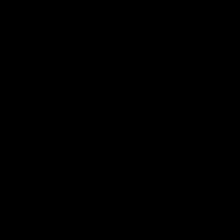

angle 3


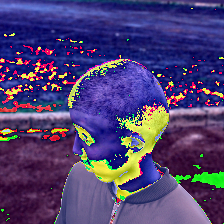

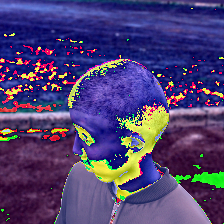

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


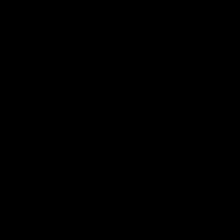

angle 28


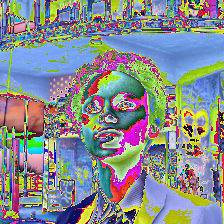

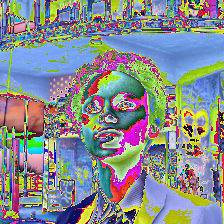

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


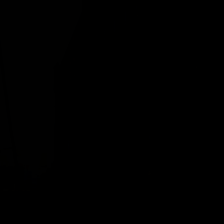

angle 3


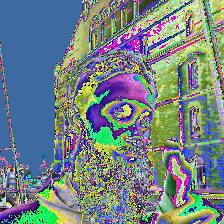

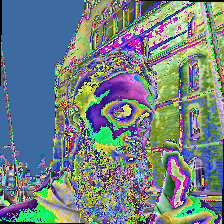

image.shape torch.Size([3, 224, 224]) keypoints.shape (70, 2)
visualize img.shape (224, 224, 3)


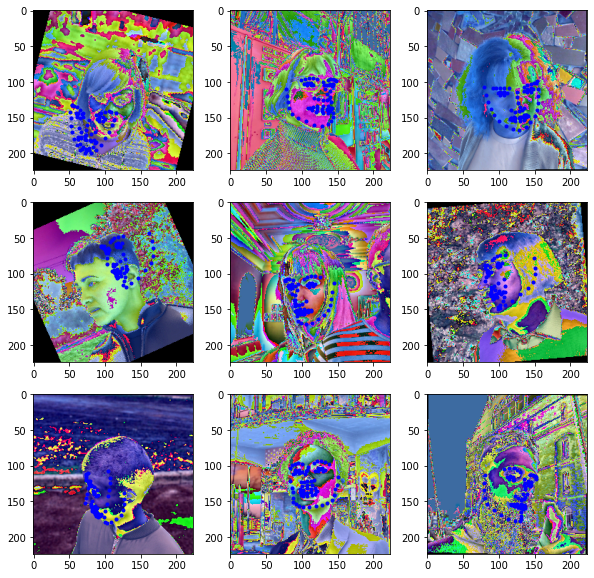

time: 4.02 s (started: 2022-12-02 05:09:36 +00:00)


In [82]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}",train=False)
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    #dataset_keypoints_plot(valid_data)
    dataset_keypoints_plot(train_data)


**Model Class**

In [ ]:
from torchvision.models import mobilenet_v3_large,MobileNet_V3_Large_Weights
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
print(model.features)
print(model)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large,MobileNet_V3_Large_Weights

class FaceKeypointMobileNetv3(nn.Module):
    def __init__(self, requires_grad):
        super(FaceKeypointMobileNetv3, self).__init__()
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(960, 1280)
        self.hardswish = nn.Hardswish()
        self.dropout = nn.Dropout(p=0.2,inplace=True)
        self.l1 = nn.Linear(1280,140)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.l0(x)
        x = self.hardswish(x)
        x = self.dropout(x)
        x = self.l1(x)
        return x

time: 12.4 ms (started: 2022-12-01 23:00:54 +00:00)


**Training**

In [8]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark 
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]
    
    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointMobileNetv3(requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test both MSELoss and SmoothL1Loss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="mobilenetv3_1k_testrun")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'sample_data/mobilenetv3_1000.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('DONE TRAINING')


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Training intermediate layer parameters...


NameError: ignored

time: 1.97 s (started: 2022-12-01 23:00:57 +00:00)


**Testing Phase**

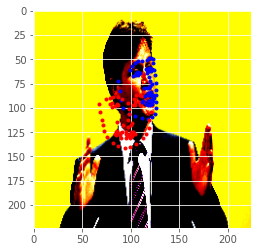

1.9618471808518139
3.1981748126311973
0.3824916402165221
2.0890839319447325
0.32519542245283284
8.506289222535239
0.36802772544854123
0.5692783233325023
9.94867196011538
0.4452323473769486
0.860754123767312
2.829278170985036
3.1521415048425463
2.07056678145245
1.930951417241536
2.1499841551573313
31.031283092852508
1.000714748428415
11.908028371429863
4.893562313360786


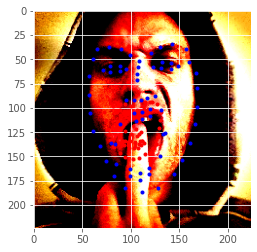

0.4996169837705741
11.523587374518165
4.817323423082626
1.3577712384988234
0.246066645932923
0.5907452912502917
3.1105526886947974
7.968220648236715
0.4354408549688711
0.16177830264167395
0.3315243751383191
1.6318548821061147
1.251396019929401
1.989627184427362
0.5249238376499987
0.8085315877258796
0.6225079428817902
0.2866553570413188
0.78436674097839
7.12131371023492


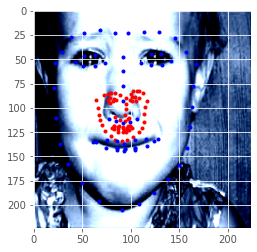

0.40498675686903035
0.3795417010137594
5.095431321833602
3.0997332453582356
1.1572408224849058
0.6535666704779289
20.736353352389017
0.3535609766483433
0.5289842611030378
4.15622761593174
5.666373998422544
0.8776189909288452
2.0649779051867196
0.26928190347304887
6.9881723036195735
3.8664930071011296
1.1423219164542853
0.32235507791194973
0.5738591869741776
8.893189254571883


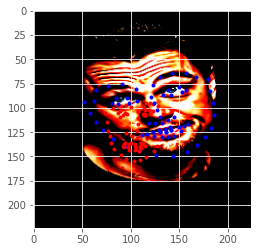

0.4152421334608434
1.70290295156305
0.37820229889602214
0.6441083593691843
0.35682168208107234
0.5197227600406835
0.4493105918269214
4.680280047943322
1.9601806424353334
0.21664728208622247
0.3465261476855106
0.5192255880065119
2.300366405960892
2.2163817733076043
5.050275069321883
13.370355642216998
1.286946644077672
3.450162101764425
0.7440814299864658
6.753448040535891


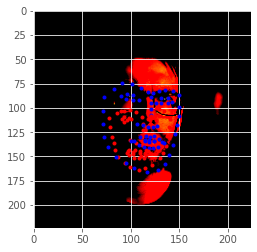

0.34070111074711507
0.8805318967752018
0.8175212765996969
3.7404689305177516
3.5882210637453262
0.23784022270342006
0.6323926257513404
1.0441419197053288
4.389929356892802
0.5712716605605254
0.4582650592180168
0.4191187214354876
1.0957912871659645
1.0333002240456068
4.419045378307378
6.819665470003469
1.266028057378622
1.6931017464858835
20.262587231063414
0.5422783129771863


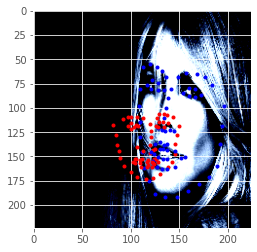

0.6172380808262558
1.1937904763808591
0.7462642390510349
1.3112762978705526
0.3300527765881761
2.0440200883112767
0.7115601305401529
1.5352756189222714
5.498869420080769
0.5110578224967671
3.349800954172831
2.1833512831302575
0.41499824199693064
19.44464480577135
1.3638107670213087
3.664580283723777
2.227173766397176
2.222149439448618
5.765881322061786
0.5720999607243817


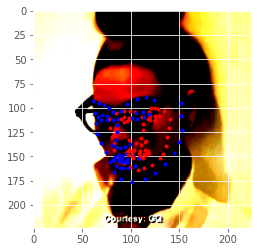

0.3398610483439395
0.36910162096681504
2.1830884501110575
0.45817276608908825
16.14073009079794
3.655178511818802
0.5992823557790338
0.3107587842118839
0.6217116523813679
16.256526362784175
3.7235190849655413
0.352761855044266
0.3137253089025847
10.387080289200387
3.5213168134141113
3.369407390677604
3.01761277215277
5.5023097670825525
12.785393329860193
1.4360640320700266


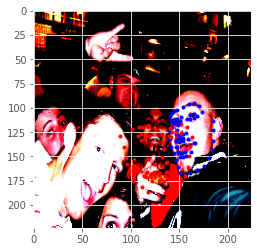

1.38527485189578
0.5296420812197511
0.3506846539558561
1.8056910409239992
0.7373025251181675
14.075560238960199
1.0787388086612435
0.6422014942707642
6.554620105117899
0.595854778773067
21.42715993063712
1.6646760747710292
1.380607740300023
1.4787825902449767
0.7276248389573269
0.8814288204298136
9.841789062525146
1.8282634968511875
1.1169718312468275
0.6555797898462988


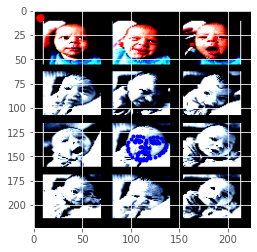

6.608009922755432
0.9169171388312943
12.270480416264643
1.1955407631857642
0.5150255196372644
0.5991811021859542
3.997745174944717
7.6245751768928605
0.3099882242195893
4.592767110154349
0.3469080698914372
1.4999782773030679
14.85109850039415
1.2943890411688799
1.3930197559371786
19.36656410342696
1.1193611964653931
0.22411709919951847
19.505501316842683
14.85785056685128


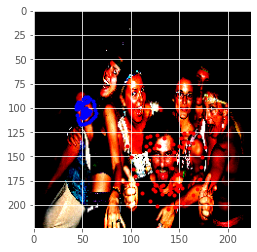

7.940347801183134
0.7597735019751739
0.6116069914922445
17.490868685459287
5.064182903816199
18.242805043190565
2.6012855597347775
2.9526626297474574
0.38317696292489994
5.646331523737888
8.275723715364261
15.161962262528005
4.592635536997724
0.31835838025321356
0.9406704455371158
0.39991658993378704
2.745645506207393
17.65683974252914
0.9809757633592342
0.8055300819189828


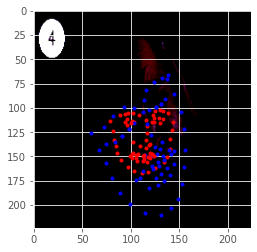

0.3378255651350953
2.001820121350424
0.4419347347213952
15.430083666130166
0.6839207403431096
0.40003381793896237
23.896106777493376
0.4814232647409854
1.035228970217008
3.540767346796321
1.857159752595095
5.525500876455791
2.483938678559544
1.362609377452857
2.8808824787209315
7.498758605597948
0.48121673934765324
2.84151906393343
1.0185554657675482
0.7884415761312026


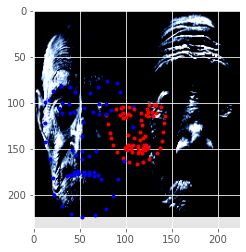

1.1178757242417974
0.5377835316867466
6.772645846938067
1.1521627486187243
15.590847811408908
1.6613197022536872
3.701241795810231
0.33036042809883903
0.5436567958087515
5.927518011953701
1.7016437597086895
4.2752537537715405
24.877608657798717
2.5621639155491587
5.256161042049211
6.2675799506697505
1.1148448986849697
7.031306046979709
14.453755777071098
1.3133318523157895


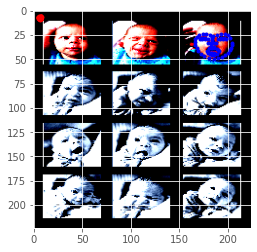

6.926000680369376
0.34583402111396144
0.3114442843392085
0.5185602627506531
1.8343596999025509
1.1481040070544304
7.8151925547293954
0.5768357209954225
0.5356197831585539
13.404192089553595
0.6970411915918553
0.8534610664089456
0.8706767011228032
0.38281999201921124
0.589971383757157
1.7971812848920699
1.2827773253102128
0.30112887592313775
0.34344165548346106
0.7346629109422237


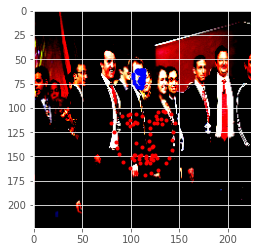

10.977652019850122
0.712839702317033
18.056626024915502
5.965466355245208
1.018336358570312
0.5474370631883618
0.7562512786912291
0.40346409004797357
6.394764310344376
14.778162744417743
2.2468174877389626
0.5078153377891147
0.3569642324440934
1.4599415261352755
3.632901337004997
0.6668438840059194
0.5552212054547364
1.7574322498528445
3.4512895080260186
0.9915153325575524


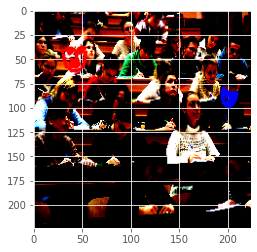

17.77389682325913
2.025355762695133
0.661271401719002
5.532292333656288
1.4202884344110343
0.4132149621863627
2.889601320950748
10.79064745143499
0.3516725418990344
0.3294472529217321
0.8573840856700674
0.683943370328762
0.29842426359161817
25.089652353334568
2.017073859751906
2.5565978581698023
0.36743886006849813
5.550354978325489
5.421456423715943
4.879934357518623


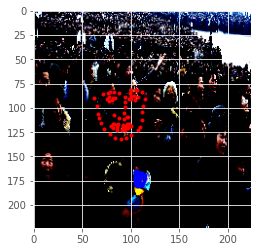

10.571983267754598
11.054562596218464
1.3947632673196861
1.81588350900838
21.56964211893035
2.576694321723183
5.215703386436528
1.7149622791128383
3.919208865632603
1.595060945641628
2.8495252998205323
6.011045714239207
1.058841570337189
1.2000910457595921
2.3174307983586537
26.479541941355166
4.282298241651999
0.798835818883254
2.272618679109977
0.31930722833907343


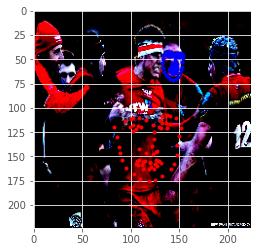

6.899063192486185
8.686867292056833
4.457837716989099
9.230304133896535
1.9881463542863886
2.127321640853075
1.172287273892165
3.796340445913857
16.959212408472588
1.385864126314362
0.5921436336810361
1.1061222578050993
0.4792517713944618
2.621326068557756
6.749335944319216
0.441360219447021
2.5202336503000984
0.5844407156368199
1.5206248296773333
1.9928379853832685


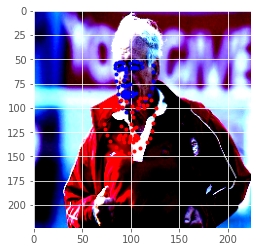

2.209754189607688
9.217076941306246
24.982834255414627
3.1009427983396396
10.332480045334023
6.9891226692269734
0.5288461870556227
0.7322353128936909
1.1060374026791855
2.5508545963686173
0.8671771097866803
0.6311811455371572
7.693398865157837
1.638426759345506
3.1366650733749593
17.319798628672075
3.079496547044896
3.9015236455802826
0.8393280206498186
24.01237378110526


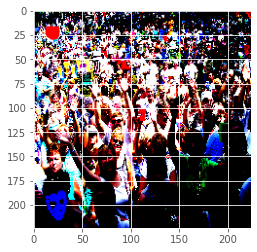

15.366471195339914
0.6216397675005291
0.9193685913145889
8.82854521524167
17.04083984855106
7.897694971464776
4.090140346983717
4.893371850251994
0.9556854467081072
12.432056771241797
6.808188238630692
5.519226854674943
23.00485038303993
8.3571343266411
2.658235937856656
0.43149467144834097
0.411400955222947
1.5019323378063911
13.252464965023535
0.28143348286814607


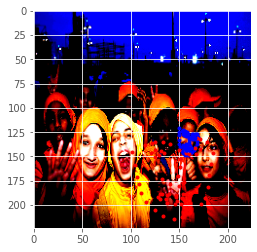

3.047958185350021
2.493105043516217
1.4996664412394174
5.176674578274383
0.46999542805849115
0.5320859539117283
7.715167261117412
5.442124190239282
0.9947016523759407
17.157218946556235
3.2024901170425726
14.0528533549233
8.887267443329975
1.4854138402787072
11.037961469013494
6.60330594628482
0.6123756096595966
4.773328347103487
8.615311295392566
28.587780833779675


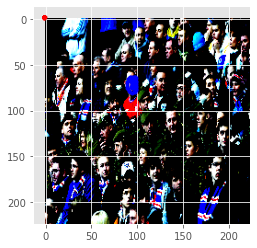

20.125499023100836
2.818921215311763
4.718198393189727
11.224541671843662
3.9792510361215414
0.3259051337434103
9.666633625349945
4.733104688234747
1.2087731966195736
2.8404496875493566
5.612956484213949
0.34332167939298247
12.455515586691282
3.110275940030763
4.99238963776884
6.678584865743597
0.273466824680362
2.3626255957473847
5.932797465950064
13.114086710087708


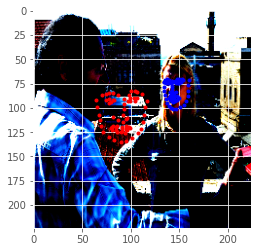

3.8288974678773697
2.319696000193366
7.474912606010356
3.6566254354057754
0.7658034214200898
1.880475467556174
8.57098368884012
2.4453294836722534
0.7708633220230544
2.070683440159061
0.840644491138767
7.905670080312462
5.011769832637558
12.536131577659994
13.718402270955872
18.58611106847073
33.7739472235718
11.916173144006668
34.300645195143204
1.317204352190973


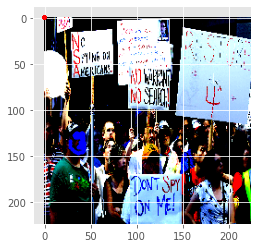

18.290293191581167
0.7557579037576365
0.5376437103291665
0.5305498101170553
1.4664222862081562
2.4598030277739222
43.616105043194246
1.7471279973352736
10.800997051829084
28.133880847303864
0.5149202045782634
7.911226639319512
3.839337801985215
7.956353253867816
0.4334261430796518
0.5044724850940754
0.5224079156988323
0.8329958696835637
0.7030229551087822
11.703991485290368


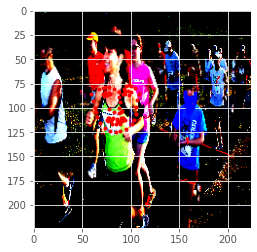

10.861798511551607
0.8757902916904559
0.21668301922889682
2.319512790364457
6.95093415013929
2.7856284191413043
0.5737280655047249
1.1434815568632617
32.314443987840136
0.9736598156779133
18.695342019605196
20.010326971353646
22.979451787636123
5.623389212823388
0.4100852911223308
3.4308731468680476
1.297103974178478
0.8095614481501959
18.871073540524222
7.407775549123747


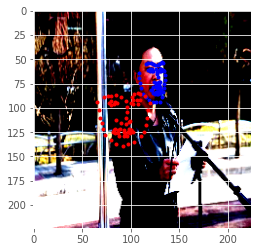

3.336622787271974
0.31859954527775486
8.731065601138576
8.496303424814077
15.156531189289518
12.509431999898316
1.6246535402280449
0.8547448899192618
1.3152643970879427
8.100096096472841
3.792370358728682
0.5478214342916559
2.171901070699938
4.919682924551962
6.710647757274973
2.1622046307006233
0.9314003747413491
5.158604268603688
0.25071334221888875
0.36664586701597723


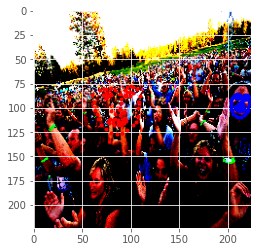

10.740934071654909
1.8979340230222055
1.650372261218144
0.5111111281408633
17.154583544814255
1.3635841714901489
1.9370146568577435
1.4567374463439868
3.0882598330781996
8.679856611608765
1.2813417077807634
0.4791369515089379
35.804712494424265
6.782070918465811
3.28212885796077
2.9216824806765422
0.30404241792198844
1.8311682614520575
18.07508197821199
14.282556972147523


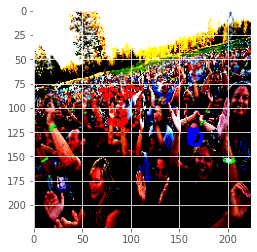

10.794781044083448
2.003605709136301
11.695912307122114
10.940152984796358
3.5264452368550945
0.6544515037857728
6.993833030812003
5.8894134632080375
1.8279640993529536
0.4318099092970893
0.9749094985700261
0.7618615182650323
16.524077969061906
7.426145605742606
0.33707971110298046
2.064888280982025
10.459302200187977
3.895189097033584
1.7121150567657597
1.3251646561402395


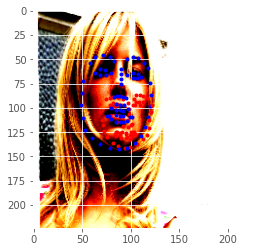

0.5489409548662848
0.4167720918129617
5.406022663523792
3.318202343451973
3.130467536441249
8.23658141716091
2.339105006368975
1.1202018871230406
10.657597244492788
33.203347079034046
0.4166255078819562
15.677335115847008
1.3102060437560246
7.560132470731378
13.984804345396272
13.081099222666786
0.5423015208438131
5.901991727943494
1.0773775939047472
1.4979454116205062


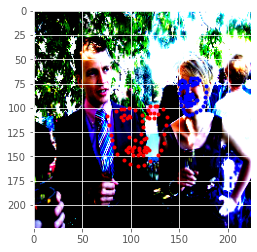

3.95759488096646
0.45011994572994424
25.946817532734464
1.300085009843903
4.5549192943025885
1.0193348667712498
0.6129993857468524
3.7622564026621914
2.0550600446044385
13.695382275314723
3.41264192904273
23.18100487329606
8.63374941970207
25.456861753782444
0.9452046082815057
11.202162963085208
4.858235552452541
1.7503777383117762
20.276201933610068
0.6583429562916537


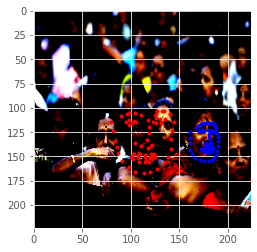

3.912205073257
3.771529135039475
0.5758209821790297
1.950684906125767
20.759674686143516
7.27845630520667
7.597787009211601
1.5712343975175418
2.5562112789047284
2.515838273309688
2.956961858431858
0.6210274594856403
2.2854266440482154
13.928756706463801
1.3803157699618263
6.765100638128727
18.545568716222682
10.055888433587654
1.4834649520081729
0.650412781607487
Average NME: 5.028346100227914
time: 5min 54s (started: 2022-12-01 19:49:50 +00:00)


In [16]:
#Run model on test data from 300WLPA dataset and report NME

#model.load_state_dict(torch.load('sample_data/resnet50_1000.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300W_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

In [ ]:
model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
checkpoint = torch.load('sample_data/my_model_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break